# 환경설정

In [2]:
import torch
import torch.nn as nn

In [3]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("현재 디바이스: {}".format(device))

torch.manual_seed(777) # 재현성을 위한 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777) # gpu 쓸 땐 모든 seed 고정

현재 디바이스: cuda


## 하이퍼파라미터

In [5]:
learning_rate = 0.001 # 학습률
training_epochs = 15 # 반복 수
batch_size = 100 # 한번에 데이터 얼마나

# 데이터

In [6]:
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(),
                         download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.2MB/s]


In [7]:
one_data, one_label = mnist_train[0]
print(f"Data shape: {one_data.shape}") # 28x28 이미지

Data shape: torch.Size([1, 28, 28])


In [8]:
unique_labels = torch.unique(mnist_train.targets)
print(f"Unique labels in mnist_train: {unique_labels.tolist()}")

Unique labels in mnist_train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


dataloader: 데이터를 더 간단하게 다루는 도구

In [9]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True, # 랜덤으로 섞어주고
                                          drop_last=True) # batch_size로 나눴을 때 나머지 버림

# 모델링

In [10]:
class CNN(torch.nn.Module):

    def __init__(self):
        # 28x28 이미지 ?장 들어옴
        super(CNN, self).__init__()
        # input(?,28,28,1) -> Conv(?,28,28,32) -> pool(?,14,14,32) -> output
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # 3x3 필터를 32개
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)) #2x2 2칸씩 움직이며 최댓값 뽑기
        # input(?,14,14,1) -> Conv(?,14,14,64) -> pool(?,7,7,64) -> output
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 3x3 필터 64개
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # fully-connected -> output(10)
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        torch.nn.init.xavier_uniform_(self.fc.weight)
        # 이 계층만 가중치 초기화
        ## 신호의 분산을 줄이기? 학습 제대로 잘되게?

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [11]:
model = CNN().to(device)

In [12]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 600


# 학습

In [14]:
for epoch in range(training_epochs):
    avg_cost = 0  # 에포크당 평균 비용을 저장

    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()  # 옵티마이저 초기화
        hypothesis = model(X) # 순전파
        cost = criterion(hypothesis, Y) # 비용 계산
        cost.backward()  # 비용을 바탕으로 역전파
        optimizer.step()  # 옵티마이저를 통해 파라미터 업데이트

        avg_cost += cost / total_batch

    # 에포크가 끝날 때마다 평균 비용 출력
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.225605488
[Epoch:    2] cost = 0.0630505905
[Epoch:    3] cost = 0.046304103
[Epoch:    4] cost = 0.037447378
[Epoch:    5] cost = 0.0314384922
[Epoch:    6] cost = 0.0261364151
[Epoch:    7] cost = 0.0218005888
[Epoch:    8] cost = 0.0184124094
[Epoch:    9] cost = 0.0163151566
[Epoch:   10] cost = 0.0133851394
[Epoch:   11] cost = 0.0100225611
[Epoch:   12] cost = 0.0102338269
[Epoch:   13] cost = 0.00835582148
[Epoch:   14] cost = 0.00658802269
[Epoch:   15] cost = 0.00686953776


# 검증

In [15]:
# 학습을 진행하지 않을 것이므로 torch.no_grad() 사용
with torch.no_grad():
    # test dataset
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    # 예측
    prediction = model(X_test)
    # 비교
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    # 참고: 반복문 없이 바로 텐서 모음에서 계산 후 평균구함

    # 정확도 계산
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9858999848365784


/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## 실제 테스트

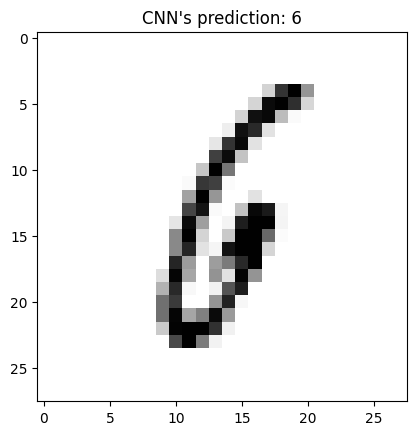

In [20]:
import matplotlib.pyplot as plt
import random

model.eval()

# 임의의 test 샘플에 대해 예측
r = random.randint(0, len(mnist_test) - 1)

X_single = mnist_test.data[r:r+1].view(1, 1, 28, 28).float().to(device)
Y_single = mnist_test.targets[r:r+1].to(device)

with torch.no_grad():
    prediction = model(X_single)
    predicted_label = torch.argmax(prediction, 1).item()

plt.imshow(mnist_test.data[r:r+1].view(28, 28).cpu(), cmap='Greys', interpolation='nearest')
plt.title(f"CNN's prediction: {predicted_label}")
plt.show()

# 추가: 더 깊은 CNN...

## 모델링

In [28]:
class CNN_2(torch.nn.Module):

    def __init__(self):
        self.keep_prob = 0.5 # 드롭아웃 확률

        # 28x28 이미지 ?장 들어옴
        super(CNN_2, self).__init__()
        # input(?,28,28,1) -> Conv(?,28,28,32) -> pool(?,14,14,32) -> output
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # 3x3 필터를 32개
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)) #2x2 2칸씩 움직이며 최댓값 뽑기
        # input(?,14,14,32) -> Conv(?,14,14,64) -> pool(?,7,7,64) -> output
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 3x3 필터 64개
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # input(?,7,7,64) -> Conv(?,7,7,128) -> pool(?,4,4,128) -> output
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # 3x3 필터 128개
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))
        # linear(?,4,4,128) -> output
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        # fully-connected -> output(10)
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        # 이 계층만 가중치 초기화
        ## 신호의 분산을 줄이기? 학습 제대로 잘되게?

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.layer4(out)
        out = self.fc2(out)
        return out


In [29]:
model_2 = CNN_2().to(device)

In [30]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)

In [31]:
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 600


## 학습

In [32]:
for epoch in range(training_epochs):
    avg_cost = 0  # 에포크당 평균 비용을 저장

    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()  # 옵티마이저 초기화
        hypothesis = model_2(X) # 순전파
        cost = criterion(hypothesis, Y) # 비용 계산
        cost.backward()  # 비용을 바탕으로 역전파
        optimizer.step()  # 옵티마이저를 통해 파라미터 업데이트

        avg_cost += cost / total_batch

    # 에포크가 끝날 때마다 평균 비용 출력
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.183557734
[Epoch:    2] cost = 0.0512934402
[Epoch:    3] cost = 0.034880463
[Epoch:    4] cost = 0.0288580321
[Epoch:    5] cost = 0.0227484461
[Epoch:    6] cost = 0.0172072053
[Epoch:    7] cost = 0.0161845628
[Epoch:    8] cost = 0.0151925506
[Epoch:    9] cost = 0.011782093
[Epoch:   10] cost = 0.0122091407
[Epoch:   11] cost = 0.00910573918
[Epoch:   12] cost = 0.00842287764
[Epoch:   13] cost = 0.00926483981
[Epoch:   14] cost = 0.00691803684
[Epoch:   15] cost = 0.00740321074


## 검증

In [33]:
# 학습을 진행하지 않을 것이므로 torch.no_grad() 사용
with torch.no_grad():
    # test dataset
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    # 예측
    prediction = model_2(X_test)
    # 비교
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    # 참고: 반복문 없이 바로 텐서 모음에서 계산 후 평균구함

    # 정확도 계산
    accuracy = correct_prediction.float().mean()
    print('Accuracy of deeper CNN:', accuracy.item())

Accuracy of deeper CNN: 0.9817999601364136


/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


층을 더 쌓는다고 무조건 성능향상은 아님